### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

### Helper Feature Extraction Functions

In [2]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='inner').fillna(1)
    return df#.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def log_returns(waps):
    return -np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

### Generating Features for Stock X

In [3]:
def generate_features(file_path):
    
    df = pd.read_csv(file_path)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    # import pre-computed beta as feature for each stock
    #df['beta'] = df.groupby('stock_id').apply(import_beta)
    
    # target is volatility at t = 600 seconds i.e. over entire time bucket
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean],#, mad, np.max, np.sum],
        'wap2':[np.mean],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility],
        'log_returns2':[realized_volatility],
        'wap_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff2':[np.mean],#, mad, np.max, np.sum],
        'bid_diff':[np.mean],#, mad, np.max, np.sum],
        'ask_diff':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean],#, mad, np.max, np.sum],
        'dom':[np.mean],#, mad, np.max, np.sum],
        'dom_diff':[np.mean],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean],#, mad, np.max, np.sum],
        #'beta':[np.mean, mad, np.max, np.sum]
    }

    #####groupby / target realized volatility for entire window
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(target_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col).rstrip('_') for col in df_feature.columns if len(col) > 1] 
    
    ######groupby / last XX seconds     # 0         300|         600
    last_seconds = [300]
    
    for second in last_seconds:
    
        df_feature_sec = pd.DataFrame(
            df.query(f'{300-second} <= seconds_in_bucket <= {300}')
              .groupby(['time_id']).agg(feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col).rstrip('_') for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        df_feature = pd.merge(df_feature, df_feature_sec, 
                              how='left', 
                              left_on='time_id', 
                              right_on=f'time_id_{second}')
        
        df_feature = df_feature.drop([f'time_id_{second}'],axis=1)
        
    #create stock_id
    df_feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    df_feature['time_id'] = df_feature['time_id'].apply(int)
    
    return df_feature

In [4]:
def concat_features(stock_id, df):
    file = "individual_book_train/stock_" + str(stock_id) + ".csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(list_stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(delayed(concat_features)(stock_id, df) for stock_id in list_stock_ids)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(pd.concat(df, ignore_index = True))

In [5]:
list_stock_ids = [0, 1]
process_stocks(list_stock_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.7s finished


,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,dom_mean_300,dom_diff_mean_300,dom_imbalance_mean_300,bid_ask_spread1_mean_300,bid_ask_spread2_mean_300,bid_ask_spread3_mean_300,stock_id,beta,dom,spread
0,5,0.004499,1.003596,1.003511,0.003394,0.005032,0.000430,0.000899,0.001182,0.000150,...,344.601790,130.657743,213.944047,0.000899,0.001183,0.000284,0,1.208072,313.922175,0.000865
1,11,0.001204,0.999988,0.999983,0.000699,0.001448,0.000174,0.000500,0.000778,0.000124,...,304.392845,134.701292,169.691553,0.000500,0.000779,0.000278,0,1.719756,380.683774,0.000432
2,16,0.002369,0.999961,1.000107,0.001983,0.003583,0.000304,0.000729,0.001136,0.000235,...,413.803348,136.209455,277.593894,0.000729,0.001136,0.000407,0,7.164047,417.199888,0.000733
3,31,0.002574,0.999218,0.998833,0.001863,0.002422,0.000427,0.000900,0.001158,0.000151,...,461.367713,124.847319,336.520394,0.000900,0.001159,0.000258,0,6.559597,465.014775,0.000898
4,62,0.001895,0.999768,0.999685,0.001131,0.002412,0.000202,0.000366,0.000637,0.000184,...,255.070445,126.433159,128.637286,0.000366,0.000637,0.000271,0,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,32751,0.003723,1.000154,1.000019,0.003013,0.004029,0.000369,0.000590,0.000860,0.000142,...,259.848195,120.857421,138.990774,0.000590,0.000861,0.000271,1,0.225453,285.711186,0.000602
5348,32753,0.010829,1.003135,1.002986,0.006710,0.006974,0.000332,0.000763,0.001004,0.000121,...,647.661857,294.005082,353.656775,0.000763,0.001005,0.000242,1,28.996320,568.986705,0.000928
5349,32758,0.003135,1.000472,1.000501,0.002322,0.003128,0.000215,0.000677,0.000928,0.000136,...,418.188825,209.133653,209.055172,0.000677,0.000929,0.000252,1,1.602334,429.906110,0.000654
5350,32763,0.003750,1.001606,1.001618,0.002574,0.003697,0.000201,0.000429,0.000866,0.000216,...,532.149823,131.073929,401.075894,0.000429,0.000867,0.000438,1,3.980220,523.056313,0.000418


### Generate Train-Test Split

In [6]:
def train_test_split_ids(n = 7):
    stock_ids = pd.read_csv("all_times.csv").stock_id.unique()
    n = len(stock_ids)
    return stock_ids[0:7*(n//10)], stock_ids[7*(n//10):]

train_ids, test_ids = train_test_split_ids(7)
print(f"Train set size:\t{len(train_ids)}\nTest set size:\t{len(test_ids)}")

df_train = process_stocks(train_ids)
df_test = process_stocks(test_ids)

Train set size:	77
Test set size:	35


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


In [7]:
from sklearn.model_selection import KFold

tmp_train = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
for idx_1, idx_2 in kf.split(df_train):
    tmean = df_train.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
    tmp_train[idx_2] = df_train['stock_id'].iloc[idx_2].map(tmean)
    
tmp_test = np.repeat(np.nan, df_test.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
for idx_1, idx_2 in kf.split(df_test):
    tmean = df_test.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
    tmp_test[idx_2] = df_test['stock_id'].iloc[idx_2].map(tmean)
    
df_train['target_mean_enc'] = tmp_train
df_test['target_mean_enc'] = tmp_test

In [8]:
df_train

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,dom_diff_mean_300,dom_imbalance_mean_300,bid_ask_spread1_mean_300,bid_ask_spread2_mean_300,bid_ask_spread3_mean_300,stock_id,beta,dom,spread,target_mean_enc
0,5,0.004499,1.003596,1.003511,0.003394,0.005032,0.000430,0.000899,0.001182,0.000150,...,130.657743,213.944047,0.000899,0.001183,0.000284,0,1.208072,313.922175,0.000865,0.004363
1,11,0.001204,0.999988,0.999983,0.000699,0.001448,0.000174,0.000500,0.000778,0.000124,...,134.701292,169.691553,0.000500,0.000779,0.000278,0,1.719756,380.683774,0.000432,0.004357
2,16,0.002369,0.999961,1.000107,0.001983,0.003583,0.000304,0.000729,0.001136,0.000235,...,136.209455,277.593894,0.000729,0.001136,0.000407,0,7.164047,417.199888,0.000733,0.004383
3,31,0.002574,0.999218,0.998833,0.001863,0.002422,0.000427,0.000900,0.001158,0.000151,...,124.847319,336.520394,0.000900,0.001159,0.000258,0,6.559597,465.014775,0.000898,0.004376
4,62,0.001895,0.999768,0.999685,0.001131,0.002412,0.000202,0.000366,0.000637,0.000184,...,126.433159,128.637286,0.000366,0.000637,0.000271,0,0.680616,332.463664,0.000401,0.004424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206047,32751,0.002856,0.997416,0.997402,0.002235,0.002719,0.000077,0.000231,0.000579,0.000175,...,330.752431,1237.368916,0.000231,0.000579,0.000348,86,5.170807,1457.800724,0.000244,0.002937
206048,32753,0.003425,0.998688,0.998793,0.001629,0.002433,0.000180,0.000344,0.000710,0.000167,...,360.118429,985.726403,0.000344,0.000711,0.000366,86,6.386436,1426.998051,0.000412,0.002947
206049,32758,0.001839,1.000395,1.000268,0.001559,0.001930,0.000142,0.000285,0.000664,0.000191,...,318.511594,1067.907672,0.000285,0.000665,0.000379,86,-0.599727,1381.004326,0.000268,0.002929
206050,32763,0.001741,0.999924,0.999895,0.001252,0.001719,0.000085,0.000252,0.000755,0.000252,...,1700.567629,5610.416839,0.000252,0.000755,0.000503,86,1.638146,7513.774378,0.000252,0.002961


In [9]:
df_test

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,...,dom_diff_mean_300,dom_imbalance_mean_300,bid_ask_spread1_mean_300,bid_ask_spread2_mean_300,bid_ask_spread3_mean_300,stock_id,beta,dom,spread,target_mean_enc
0,5,0.007274,1.001635,1.001597,0.005066,0.004922,0.000287,0.000799,0.001053,0.000126,...,245.774960,137.036598,0.000799,0.001053,0.000254,87,2.735538,428.047446,0.000864,0.005036
1,11,0.003592,1.000866,1.000883,0.002959,0.003299,0.000384,0.000659,0.000931,0.000126,...,121.444553,233.741697,0.000659,0.000931,0.000272,87,6.081658,396.532238,0.000608,0.005091
2,16,0.002198,0.999581,0.999637,0.001820,0.002171,0.000134,0.000421,0.000670,0.000130,...,160.655144,397.154787,0.000421,0.000670,0.000248,87,-2.366741,547.690439,0.000425,0.005048
3,31,0.003204,1.000695,1.000617,0.002236,0.002591,0.000183,0.000635,0.000830,0.000089,...,268.544683,250.414914,0.000635,0.000831,0.000196,87,4.314395,498.828487,0.000593,0.005044
4,62,0.001842,0.998892,0.998689,0.001615,0.002326,0.000324,0.000614,0.000874,0.000144,...,215.620914,414.957801,0.000614,0.000874,0.000260,87,4.541587,572.929646,0.000529,0.005036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93690,32751,0.003691,0.999750,0.999939,0.002284,0.004503,0.000462,0.000846,0.001202,0.000098,...,169.534037,271.508484,0.000847,0.001203,0.000356,126,0.895436,418.205006,0.000870,0.005822
93691,32753,0.004104,1.001473,1.001517,0.002217,0.003652,0.000321,0.000681,0.000915,0.000132,...,142.673310,112.261866,0.000681,0.000915,0.000234,126,-1.346971,222.682585,0.000670,0.005766
93692,32758,0.003118,1.000655,1.000587,0.001386,0.002686,0.000282,0.000817,0.001086,0.000091,...,264.496859,85.062331,0.000817,0.001086,0.000269,126,0.904714,346.025217,0.000754,0.005814
93693,32763,0.003661,1.001789,1.001797,0.002783,0.004316,0.000269,0.000560,0.000854,0.000147,...,133.027658,261.412509,0.000560,0.000855,0.000295,126,-0.099107,438.588531,0.000526,0.005797


## Training LightGBM

In [11]:
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()
    
def rmspe(y_true, y_pred):
    #print(y_true, y_pred)
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


### Cross-Validation Set-up

In [29]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
models = []                         
scores = 0.0                        

gain_importance_list = []
split_importance_list = []

X = df_train.drop(['time_id','target_realized_volatility'],axis=1)  # leave stock id
y = df_train['target_realized_volatility']

params = {
      "objective": "rmse",
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'force_col_wise': True
  }

In [30]:
%%time

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      callbacks=[lgbm.log_evaluation(period=100)])
        
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred), 3)
    print("*" * 100)

    print(f'Performance RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
        
    feature_names = X_train.columns.values.tolist()

    gain_importance_df = calc_model_importance(model, feature_names=feature_names, importance_type='gain')
    gain_importance_list.append(gain_importance_df)

    split_importance_df = calc_model_importance(model, feature_names=feature_names, importance_type='split')
    split_importance_list.append(split_importance_df)

Fold : 1
[LightGBM] [Info] Total Bins 5431
[LightGBM] [Info] Number of data points in the train set: 164841, number of used features: 22
[LightGBM] [Info] Start training from score 0.001762
[100]	training's rmse: 0.000515767	training's RMSPE: 0.23973	valid_1's rmse: 0.000515346	valid_1's RMSPE: 0.2357
[200]	training's rmse: 0.000298481	training's RMSPE: 0.13873	valid_1's rmse: 0.00030086	valid_1's RMSPE: 0.1376
[300]	training's rmse: 0.000249809	training's RMSPE: 0.11611	valid_1's rmse: 0.000253974	valid_1's RMSPE: 0.11616
[400]	training's rmse: 0.000237765	training's RMSPE: 0.11051	valid_1's rmse: 0.000242976	valid_1's RMSPE: 0.11113
[500]	training's rmse: 0.000231896	training's RMSPE: 0.10779	valid_1's rmse: 0.000237739	valid_1's RMSPE: 0.10873
[600]	training's rmse: 0.00022771	training's RMSPE: 0.10584	valid_1's rmse: 0.000234069	valid_1's RMSPE: 0.10706
[700]	training's rmse: 0.000224543	training's RMSPE: 0.10437	valid_1's rmse: 0.000231399	valid_1's RMSPE: 0.10583
[800]	training's

[1100]	training's rmse: 0.000217238	training's RMSPE: 0.10057	valid_1's rmse: 0.000230388	valid_1's RMSPE: 0.10709
[1200]	training's rmse: 0.000215952	training's RMSPE: 0.09998	valid_1's rmse: 0.000229693	valid_1's RMSPE: 0.10677
Performance of the　prediction: , RMSPE: 0.107
****************************************************************************************************
Fold : 4
[LightGBM] [Info] Total Bins 5431
[LightGBM] [Info] Number of data points in the train set: 164842, number of used features: 22
[LightGBM] [Info] Start training from score 0.001771
[100]	training's rmse: 0.000515287	training's RMSPE: 0.23886	valid_1's rmse: 0.000519414	valid_1's RMSPE: 0.2402
[200]	training's rmse: 0.000298813	training's RMSPE: 0.13851	valid_1's rmse: 0.00030142	valid_1's RMSPE: 0.13939
[300]	training's rmse: 0.000250569	training's RMSPE: 0.11615	valid_1's rmse: 0.000252901	valid_1's RMSPE: 0.11695
[400]	training's rmse: 0.000238569	training's RMSPE: 0.11059	valid_1's rmse: 0.000240991	vali

### Training Stats

In [31]:
scores

0.1026

In [32]:
split_importance_df.sort_values(['importance'], ascending=False)

,importance
spread,10897
log_returns_realized_volatility_300,8826
price_diff_mean_300,8066
log_returns2_realized_volatility_300,3709
dom,3046
target_mean_enc,2693
wap_diff_mean_300,2656
bid_ask_spread1_mean_300,2433
stock_id,1989
beta,1815


In [33]:
gain_importance_df.sort_values(['importance'], ascending=False)

,importance
log_returns_realized_volatility_300,2.205848e+06
log_returns2_realized_volatility_300,3.594811e+05
spread,2.556960e+04
price_diff_mean_300,7.637237e+03
dom,3.435054e+03
wap_diff_mean_300,3.201049e+03
bid_ask_spread1_mean_300,2.334749e+03
beta,1.495690e+03
target_mean_enc,1.448444e+03
wap_mean_300,1.447327e+03


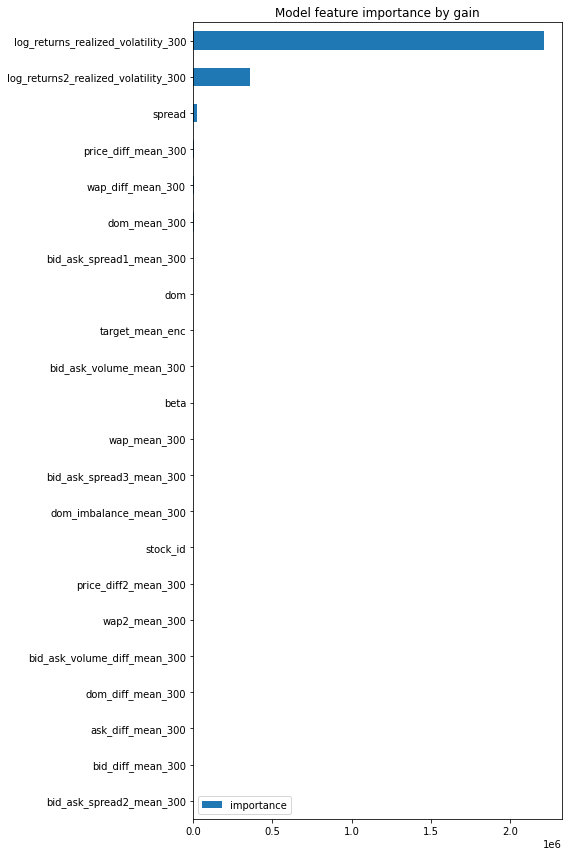

,feature_names,importance
0,bid_ask_spread2_mean_300,1.678006e+02
1,bid_diff_mean_300,2.348182e+02
2,ask_diff_mean_300,2.757653e+02
3,dom_diff_mean_300,3.360789e+02
4,bid_ask_volume_diff_mean_300,4.020645e+02
5,wap2_mean_300,5.604657e+02
6,price_diff2_mean_300,6.799168e+02
7,stock_id,7.779768e+02
8,dom_imbalance_mean_300,8.153647e+02
9,bid_ask_spread3_mean_300,8.748649e+02


In [34]:
import matplotlib

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('gain_importance_mean.csv', index=False)
    
mean_gain_df

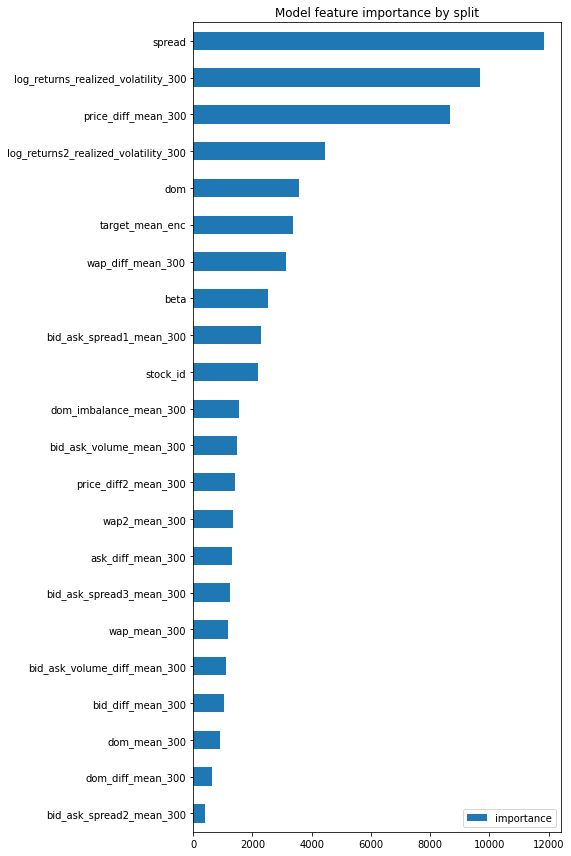

,feature_names,importance
0,bid_ask_spread2_mean_300,398.8
1,dom_diff_mean_300,640.0
2,dom_mean_300,918.6
3,bid_diff_mean_300,1053.2
4,bid_ask_volume_diff_mean_300,1117.4
5,wap_mean_300,1186.2
6,bid_ask_spread3_mean_300,1238.8
7,ask_diff_mean_300,1316.4
8,wap2_mean_300,1340.8
9,price_diff2_mean_300,1414.2


In [36]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('split_importance_mean.csv', index=False)

mean_split_df

## Test

In [37]:
y_test= df_test[['target_realized_volatility']]
X_test = df_test.drop(['time_id','target_realized_volatility'], axis = 1)

In [38]:
X_test

,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns2_realized_volatility_300,wap_diff_mean_300,price_diff_mean_300,price_diff2_mean_300,bid_diff_mean_300,ask_diff_mean_300,bid_ask_volume_mean_300,...,dom_diff_mean_300,dom_imbalance_mean_300,bid_ask_spread1_mean_300,bid_ask_spread2_mean_300,bid_ask_spread3_mean_300,stock_id,beta,dom,spread,target_mean_enc
0,1.001635,1.001597,0.005066,0.004922,0.000287,0.000799,0.001053,0.000126,-0.000129,382.199336,...,245.774960,137.036598,0.000799,0.001053,0.000254,87,2.735538,428.047446,0.000864,0.005036
1,1.000866,1.000883,0.002959,0.003299,0.000384,0.000659,0.000931,0.000126,-0.000147,354.867110,...,121.444553,233.741697,0.000659,0.000931,0.000272,87,6.081658,396.532238,0.000608,0.005091
2,0.999581,0.999637,0.001820,0.002171,0.000134,0.000421,0.000670,0.000130,-0.000118,558.073090,...,160.655144,397.154787,0.000421,0.000670,0.000248,87,-2.366741,547.690439,0.000425,0.005048
3,1.000695,1.000617,0.002236,0.002591,0.000183,0.000635,0.000830,0.000089,-0.000106,518.475083,...,268.544683,250.414914,0.000635,0.000831,0.000196,87,4.314395,498.828487,0.000593,0.005044
4,0.998892,0.998689,0.001615,0.002326,0.000324,0.000614,0.000874,0.000144,-0.000116,631.265781,...,215.620914,414.957801,0.000614,0.000874,0.000260,87,4.541587,572.929646,0.000529,0.005036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93690,0.999750,0.999939,0.002284,0.004503,0.000462,0.000846,0.001202,0.000098,-0.000259,441.232558,...,169.534037,271.508484,0.000847,0.001203,0.000356,126,0.895436,418.205006,0.000870,0.005822
93691,1.001473,1.001517,0.002217,0.003652,0.000321,0.000681,0.000915,0.000132,-0.000102,254.687708,...,142.673310,112.261866,0.000681,0.000915,0.000234,126,-1.346971,222.682585,0.000670,0.005766
93692,1.000655,1.000587,0.001386,0.002686,0.000282,0.000817,0.001086,0.000091,-0.000178,349.554817,...,264.496859,85.062331,0.000817,0.001086,0.000269,126,0.904714,346.025217,0.000754,0.005814
93693,1.001789,1.001797,0.002783,0.004316,0.000269,0.000560,0.000854,0.000147,-0.000148,393.684385,...,133.027658,261.412509,0.000560,0.000855,0.000295,126,-0.099107,438.588531,0.000526,0.005797


In [39]:
y_test

,target_realized_volatility
0,0.007274
1,0.003592
2,0.002198
3,0.003204
4,0.001842
...,...
93690,0.003691
93691,0.004104
93692,0.003118
93693,0.003661


In [40]:
target = np.zeros(len(X_test))
scores = 0.0

# take mean of predictions for all models on test features 
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [41]:
y_test = y_test.assign(predicted_volatility = target)
y_test

,target_realized_volatility,predicted_volatility
0,0.007274,0.006912
1,0.003592,0.003779
2,0.002198,0.002582
3,0.003204,0.003071
4,0.001842,0.002235
...,...,...
93690,0.003691,0.003587
93691,0.004104,0.003251
93692,0.003118,0.002367
93693,0.003661,0.003745


### Test Result

In [42]:
RMSPE = round(rmspe(y_true=y_test['target_realized_volatility'], y_pred=y_test['predicted_volatility']), 4)

print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

Performance of the　prediction: , RMSPE: 0.1049
